## Using RNNs to classify sentiment on IMDB data

In this assignment,you will train three types of RNNs:  "vanilla" RNN, LSTM and GRU to predict the sentiment on IMDB reviews.  

Keras provides a convenient interface to load the data and immediately encode the words into integers (based on the most common words). 
This will save you a lot of the drudgery that is usually involved when working with raw text.

The IMDB is  data consists of 25000 training sequences and 25000 test sequences. 
The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.



Walk through the followinng steps to prepare the data and the building of an RNN model. 

#### Import Libraries

In [182]:
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing import sequence
from tensorflow.keras import optimizers
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import LSTM
import timeit
from keras.layers.recurrent import GRU
from numpy.random import seed

In [183]:
# set a seed for a reproducible results 
seed(50)

1- Use the `imdb.load_data()` to load in the data 

2- Specify the maximum length of a sequence to 20000 words and the pick the most common words to 30. 

In [184]:
max_features = 20000  # number of words to consider as features
maxlen = 30  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

In [185]:
#print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)


In [186]:
print('Loaded dataset with {} training samples, {} test samples'.format(len(x_train), len(x_test)))

Loaded dataset with 25000 training samples, 25000 test samples


3- Check that the number of sequences in train and test datasets are equal (default split):
    
Expected output:
- `x_train = 25000 train sequences`

- `x_test = 25000 test sequences`

In [187]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')


25000 train sequences
25000 test sequences


4- Pad (or truncate) the sequences so that they are of the maximum length

In [188]:
def pad_seq(x_train,x_test,maxlen):
    print('Pad sequences (samples x time)')
    x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
    x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
    
    return x_train,x_test

5- After padding or truncating, check the dimensionality of x_train and x_test.

Expected output:
- `x_train shape: (25000, 30)`
- `x_test shape: (25000, 30)`

In [189]:
#Copy x_train and x_test to x_train1 and x_test1 for the building the first model with maxlen = 30

x_train1,x_test1 = pad_seq(x_train,x_test,maxlen)
print('x_train shape:', x_train1.shape)
print('x_test shape:', x_test1.shape)

Pad sequences (samples x time)
x_train shape: (25000, 30)
x_test shape: (25000, 30)


In [190]:
print(x_train1[6])
print(y_train[6])

[ 665   71  270   56    5   13  197   12  161 5390   99   76   23    2
    7  419  665   40   91   85  108    7    4 2084    5 4773   81   55
   52 1901]
1


## Keras layers for (Vanilla) RNNs

In this step, you will not use pre-trained word vectors, Instead you will learn an embedding as part of the  the Vanilla  RNNs network  Neural Network. 

In the Keras API documentation, the Embedding Layer and the SimpleRNN Layer have the following syntax:

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






6- Build the RNN with three layers: 
- The SimpleRNN layer with 5 neurons and initialize its kernel with stddev=0.001

- The Embedding layer and initialize it by setting the word embedding dimension to 50. This means that this layer takes each integer in the sequence and embeds it in a 50-dimensional vector.

-  The output layer has the sigmoid activation function.

In [191]:
# Function to create a baseline model

def RNN_model(max_features,embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
    model.add(SimpleRNN(5,activation='tanh',kernel_initializer=initializers.random_normal(stddev=0.001)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
                   loss='binary_crossentropy', 
                   metrics=['acc'])

    return model


### Build the baseline model with embedding dimension as 50 and optimizer as RMSprop with learning rate of .0001

In [192]:
# a list to save all trained models in thr list, called models, to be used later to plot accuracies
models = []


In [193]:
embedding_dim = 50

model1 = RNN_model(max_features,embedding_dim, maxlen)


7- How many parameters have the embedding layer?

In [194]:
model1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 30, 50)            1000000   
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 5)                 280       
                                                                 
 dense_25 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [195]:
model1.count_params()

1000286

 There are a total of 1,000,286 parameters in this model with embedding layer having 1,000,000 parameters

8- Train the network with the RMSprop with learning rate of .0001 and epochs=10.

In [196]:
history1 = model1.fit(x_train1, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 47s 75ms/step - loss: 0.6837 - acc: 0.5905 - val_loss: 0.6608 - val_acc: 0.6484
Epoch 2/10
625/625 [==============================] - 47s 75ms/step - loss: 0.6397 - acc: 0.6744 - val_loss: 0.6358 - val_acc: 0.6660
Epoch 3/10
625/625 [==============================] - 47s 75ms/step - loss: 0.6108 - acc: 0.7102 - val_loss: 0.6221 - val_acc: 0.6730
Epoch 4/10
625/625 [==============================] - 47s 75ms/step - loss: 0.5869 - acc: 0.7323 - val_loss: 0.6056 - val_acc: 0.6960
Epoch 5/10
625/625 [==============================] - 49s 78ms/step - loss: 0.5644 - acc: 0.7540 - val_loss: 0.5923 - val_acc: 0.7072
Epoch 6/10
625/625 [==============================] - 46s 73ms/step - loss: 0.5429 - acc: 0.7681 - val_loss: 0.5773 - val_acc: 0.7180
Epoch 7/10
625/625 [==============================] - 47s 75ms/step - loss: 0.5206 - acc: 0.7856 - val_loss: 0.5637 - val_acc: 0.7238
Epoch 8/10
625/625 [==============================] - 47s 76ms

9- PLot the loss and accuracy metrics during the training and interpret the result.

In [197]:
# Function to plot accuracy and loss of the model

def accuracy_loss_plot(history):
    acc=history.history['acc']
    val_acc = history.history['val_acc']
    
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    accuracy = acc[-1]  # oraccuracy= np.mean(acc) 
    accuracy_percentage = str("{:.3f}".format(accuracy))   

    val_accuracy = val_acc[-1]  # or val_accuracy=np.mean(val_acc) 
    val_accuracy_percentage =  str("{:.3f}".format(val_accuracy))
                                                           
    plt.legend(['Train Accuracy: '+ accuracy_percentage, 'Validation Accuracy: '+ val_accuracy_percentage], loc='upper left')
    plt.show()
    
    
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    loss = loss[-1] # np.mean(history['loss'])
    loss_percentage =  str("{:.3f}".format(loss))   
   
    val_loss = val_loss[-1] #np.mean(history['val_loss'])
    val_loss_percentage =  str("{:.3f}".format(val_loss))
    
    plt.legend(['Training Loss: '+loss_percentage, 'Validation Loss: '+val_loss_percentage], loc='upper left')
    plt.show()
    
   

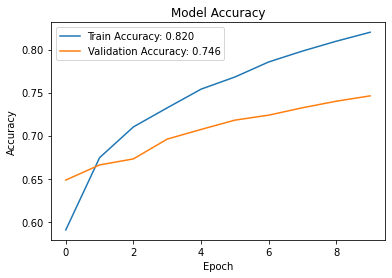

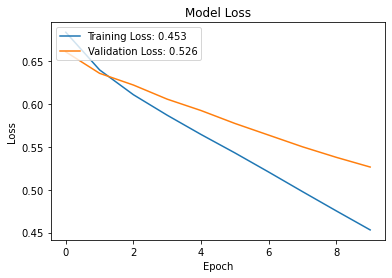

In [198]:
accuracy_loss_plot(history1)

 The training accuracy reaches around 82% where as the validation is only 74%. So, the model is overfitting. 

10- Check the accuracy and the loss of your models on the test dataset.

In [199]:
#Evaluate the accuracy on test
m1 = model1.evaluate(x_test1, y_test)


782/782 [==============================] - 9s 12ms/step - loss: 0.5216 - acc: 0.7486: 1s - l


In [200]:
# Evaluate performance of the test dataset
accuracy = m1[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['BaselineModel_Maxlen_30: ',m1[1]*100])
models

Accuracy Testing dataset: 74.86


[['BaselineModel_Maxlen_30: ', 74.86400008201599]]

Testing accuracy is 74% which is almost the same as the validation accuracy. 

## Tuning The Vanilla RNN Network


### Model 2 with maxlen  = 80

11- Prepare the data to use sequences of length 80 rather than length 30 and retrain your model.  Did it improve the performance?


In [201]:
maxlen = 80 # Changing the maxlen to 80

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train2, x_test2 = pad_seq(x_train,x_test, maxlen)
model2 = RNN_model(max_features,embedding_dim, maxlen)


Pad sequences (samples x time)


In [202]:
model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 80, 50)            1000000   
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 5)                 280       
                                                                 
 dense_26 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [203]:
history2 = model2.fit(x_train2, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 111s 176ms/step - loss: 0.6931 - acc: 0.5027 - val_loss: 0.6929 - val_acc: 0.5216
Epoch 2/10
625/625 [==============================] - 107s 170ms/step - loss: 0.6901 - acc: 0.5498 - val_loss: 0.6922 - val_acc: 0.5150
Epoch 3/10
625/625 [==============================] - 109s 174ms/step - loss: 0.6777 - acc: 0.5810 - val_loss: 0.6978 - val_acc: 0.5052
Epoch 4/10
625/625 [==============================] - 124s 198ms/step - loss: 0.6610 - acc: 0.6202 - val_loss: 0.7022 - val_acc: 0.5136
Epoch 5/10
625/625 [==============================] - 120s 193ms/step - loss: 0.6450 - acc: 0.6502 - val_loss: 0.7073 - val_acc: 0.5072
Epoch 6/10
625/625 [==============================] - 115s 183ms/step - loss: 0.6291 - acc: 0.6755 - val_loss: 0.7105 - val_acc: 0.5144
Epoch 7/10
625/625 [==============================] - 117s 187ms/step - loss: 0.6146 - acc: 0.6979 - val_loss: 0.7152 - val_acc: 0.5106
Epoch 8/10
625/625 [============================

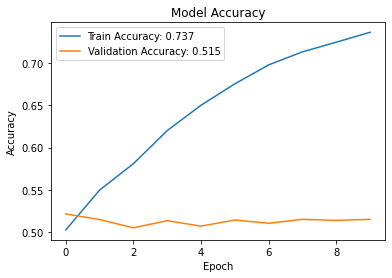

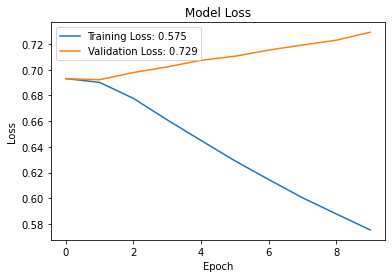

In [204]:
accuracy_loss_plot(history2)


In [205]:
# Evaluate performance of the test dataset
m2 = model2.evaluate(x_test2, y_test)

782/782 [==============================] - 15s 20ms/step - loss: 0.7279 - acc: 0.5093 0s - loss: 0.7284 - acc: 0.


In [206]:

accuracy = m2[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model2-Maxlen_80:       ',m2[1]*100])
models

Accuracy Testing dataset: 50.93


[['BaselineModel_Maxlen_30: ', 74.86400008201599],
 ['Model2-Maxlen_80:       ', 50.92800259590149]]

Testing accuracy is only 51% which is almost near to the validation accuracy. But, we understand that when we increase the sequences of length of a sentence the accuracy decreases.

### Model 3 with vocabulary size as 10,000


Reduce the maximum vocabulary length to 10000 and validate if it improves the accuracy of the model.

In [207]:
max_features = 10000  # number of words to consider as features
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
embedding_dim = 50


In [208]:
#Load data with vocabulary size as 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Copy x_train and x_test to x_train3 and x_test3 for the building the model
x_train3,x_test3 = pad_seq(x_train,x_test,maxlen)

Pad sequences (samples x time)


In [209]:
print('x_train shape:', x_train3.shape)
print('x_test shape:', x_test3.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [210]:

model3 = RNN_model(max_features,embedding_dim, maxlen)
model3.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 80, 50)            500000    
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 5)                 280       
                                                                 
 dense_27 (Dense)            (None, 1)                 6         
                                                                 
Total params: 500,286
Trainable params: 500,286
Non-trainable params: 0
_________________________________________________________________


In [211]:
history3 = model3.fit(x_train3, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 108s 171ms/step - loss: 0.6832 - acc: 0.5864 - val_loss: 0.6666 - val_acc: 0.6552
Epoch 2/10
625/625 [==============================] - 111s 177ms/step - loss: 0.6477 - acc: 0.6960 - val_loss: 0.6359 - val_acc: 0.7096
Epoch 3/10
625/625 [==============================] - 109s 175ms/step - loss: 0.6138 - acc: 0.7448 - val_loss: 0.6138 - val_acc: 0.7246
Epoch 4/10
625/625 [==============================] - 111s 178ms/step - loss: 0.5821 - acc: 0.7774 - val_loss: 0.5869 - val_acc: 0.7498
Epoch 5/10
625/625 [==============================] - 107s 172ms/step - loss: 0.5543 - acc: 0.7968 - val_loss: 0.5666 - val_acc: 0.7628
Epoch 6/10
625/625 [==============================] - 108s 173ms/step - loss: 0.5270 - acc: 0.8119 - val_loss: 0.5468 - val_acc: 0.7698
Epoch 7/10
625/625 [==============================] - 103s 164ms/step - loss: 0.4993 - acc: 0.8249 - val_loss: 0.5218 - val_acc: 0.7830
Epoch 8/10
625/625 [============================

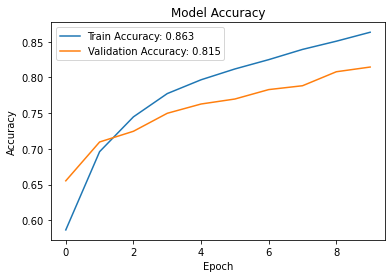

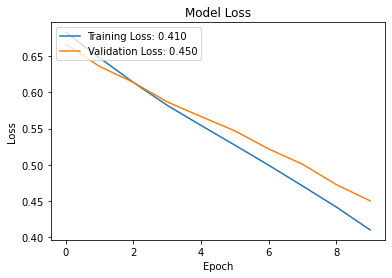

In [212]:
#Accuracy and Loss plot
accuracy_loss_plot(history3)


The accuracy increased when the max_features where reduced to 10,000

In [213]:
# Evaluate performance of the test dataset
print("Testing accuracy and Loss ")
m3 = model3.evaluate(x_test3, y_test)

Testing accuracy and Loss 
782/782 [==============================] - 15s 20ms/step - loss: 0.4636 - acc: 0.7994


In [214]:

accuracy = m3[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model3-VocabSize_10,000',m3[1]*100])
models

Accuracy Testing dataset: 79.94


[['BaselineModel_Maxlen_30: ', 74.86400008201599],
 ['Model2-Maxlen_80:       ', 50.92800259590149],
 ['Model3-VocabSize_10,000', 79.94400262832642]]

### Model 4 with vocabulary size as 40,000


#### Increase the maximum vocabulary length to 40000 and validate if it improves the accuracy of the model.

In [215]:
max_features = 40000  # number of words to consider as features
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
embedding_dim = 50


In [216]:
#Load data with vocabulary size as 40000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Copy x_train and x_test to x_train4 and x_test4 for the building the model
x_train4,x_test4 = pad_seq(x_train,x_test,maxlen)

Pad sequences (samples x time)


In [217]:
print('x_train shape:', x_train4.shape)
print('x_test shape:', x_test4.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [218]:
model4 = RNN_model(max_features,embedding_dim, maxlen)
model4.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 80, 50)            2000000   
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 5)                 280       
                                                                 
 dense_28 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,000,286
Trainable params: 2,000,286
Non-trainable params: 0
_________________________________________________________________


In [219]:
history4= model4.fit(x_train4, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 104s 166ms/step - loss: 0.6931 - acc: 0.5069 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 2/10
625/625 [==============================] - 118s 189ms/step - loss: 0.6885 - acc: 0.5568 - val_loss: 0.6948 - val_acc: 0.5042
Epoch 3/10
625/625 [==============================] - 104s 166ms/step - loss: 0.6706 - acc: 0.5928 - val_loss: 0.7019 - val_acc: 0.5082
Epoch 4/10
625/625 [==============================] - 107s 171ms/step - loss: 0.6479 - acc: 0.6326 - val_loss: 0.7107 - val_acc: 0.5130
Epoch 5/10
625/625 [==============================] - 108s 173ms/step - loss: 0.6245 - acc: 0.6651 - val_loss: 0.7257 - val_acc: 0.5084
Epoch 6/10
625/625 [==============================] - 108s 173ms/step - loss: 0.6016 - acc: 0.6916 - val_loss: 0.7272 - val_acc: 0.5008
Epoch 7/10
625/625 [==============================] - 107s 171ms/step - loss: 0.5807 - acc: 0.7176 - val_loss: 0.7348 - val_acc: 0.5014
Epoch 8/10
625/625 [============================

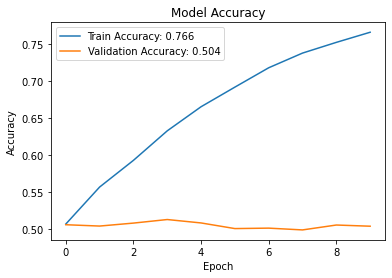

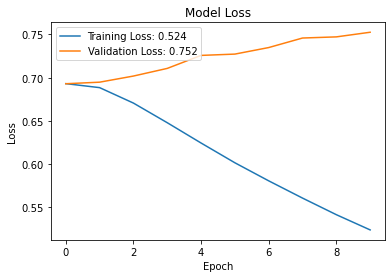

In [220]:
#Accuracy and Loss plot
accuracy_loss_plot(history4)


When we increase the vocabulary size the accuracy increases.

In [221]:

# Evaluate performance of the test dataset
print("Testing accuracy and Loss ")
m4 = model4.evaluate(x_test4, y_test)
accuracy = m4[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model4-VocabSize_40,000:',m4[1]*100])
models

Testing accuracy and Loss 
782/782 [==============================] - 15s 20ms/step - loss: 0.7492 - acc: 0.5110
Accuracy Testing dataset: 51.10


[['BaselineModel_Maxlen_30: ', 74.86400008201599],
 ['Model2-Maxlen_80:       ', 50.92800259590149],
 ['Model3-VocabSize_10,000', 79.94400262832642],
 ['Model4-VocabSize_40,000:', 51.099997758865356]]

The accuracy decreased when we increase the vocabulary size to 40000.


13- Try smaller and larger sizes of the RNN hidden dimension.  How does it affect the model performance?  How does it affect the run time?

### Model 5 with larger hidden dimension for RNN

In [222]:
max_features = 20000  
maxlen = 30
embedding_dim = 50

#Load data with vocabulary size as 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Copy x_train and x_test to x_train5 and x_test5 for the building the model
x_train5,x_test5 = pad_seq(x_train,x_test,maxlen)



Pad sequences (samples x time)


In [223]:
def build_model5(max_features,embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
    model.add(SimpleRNN(32))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
              
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
                   loss='binary_crossentropy', 
                   metrics=['acc'])    
    return model

In [224]:
model5 = build_model5(max_features,embedding_dim, maxlen)
model5.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 30, 50)            1000000   
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 32)                2656      
                                                                 
 dense_29 (Dense)            (None, 10)                330       
                                                                 
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,003,107
Trainable params: 1,003,107
Non-trainable params: 0
_________________________________________________________________


In [225]:
# set a timer to measure training time
start = timeit.default_timer()

history5= model5.fit(x_train5, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
                    
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/10
157/157 [==============================] - 18s 111ms/step - loss: 0.6929 - acc: 0.5109 - val_loss: 0.6922 - val_acc: 0.5206
Epoch 2/10
157/157 [==============================] - 18s 114ms/step - loss: 0.6872 - acc: 0.5736 - val_loss: 0.6885 - val_acc: 0.5502
Epoch 3/10
157/157 [==============================] - 17s 111ms/step - loss: 0.6717 - acc: 0.6299 - val_loss: 0.6660 - val_acc: 0.6288
Epoch 4/10
157/157 [==============================] - 17s 111ms/step - loss: 0.6373 - acc: 0.6847 - val_loss: 0.6353 - val_acc: 0.6688
Epoch 5/10
157/157 [==============================] - 17s 109ms/step - loss: 0.5894 - acc: 0.7283 - val_loss: 0.6005 - val_acc: 0.6972
Epoch 6/10
157/157 [==============================] - 20s 125ms/step - loss: 0.5378 - acc: 0.7663 - val_loss: 0.5726 - val_acc: 0.7128
Epoch 7/10
157/157 [==============================] - 20s 125ms/step - loss: 0.4884 - acc: 0.7938 - val_loss: 0.5459 - val_acc: 0.7312
Epoch 8/10
157/157 [==============================] - 1

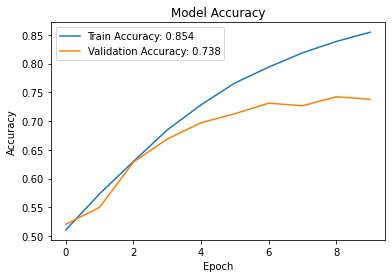

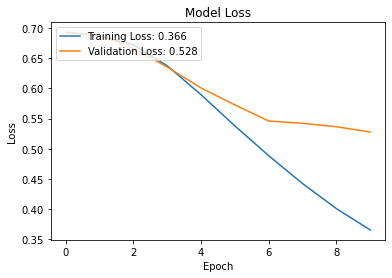

In [226]:
#Accuracy and Loss plot
accuracy_loss_plot(history5)


In [227]:
# Evaluate performance of the test dataset
print("Testing accuracy and Loss ")
m5 = model5.evaluate(x_test5, y_test)
accuracy = m5[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model5-MoreHiddenDimen ',m5[1]*100])


Testing accuracy and Loss 
782/782 [==============================] - 9s 12ms/step - loss: 0.5309 - acc: 0.7372
Accuracy Testing dataset: 73.72


### Model 6 with smaller hidden dimension

In [228]:
max_features = 20000  
maxlen = 30
embedding_dim = 50

#Load data with vocabulary size as 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Copy x_train and x_test to x_train5 and x_test5 for the building the model
x_train6,x_test6 = pad_seq(x_train,x_test,maxlen)



Pad sequences (samples x time)


In [229]:
def build_model6(max_features,embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
    model.add(SimpleRNN(10))
    model.add(Dense(1, activation='sigmoid'))
              
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
                   loss='binary_crossentropy', 
                   metrics=['acc'])    
    return model

In [230]:
model6 = build_model6(max_features,embedding_dim, maxlen)
model6.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 30, 50)            1000000   
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 10)                610       
                                                                 
 dense_32 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,000,621
Trainable params: 1,000,621
Non-trainable params: 0
_________________________________________________________________


In [231]:
# set a timer to measure training time
start = timeit.default_timer()

history6= model6.fit(x_train6, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
                    
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/10
157/157 [==============================] - 19s 114ms/step - loss: 0.6883 - acc: 0.5387 - val_loss: 0.6748 - val_acc: 0.5946
Epoch 2/10
157/157 [==============================] - 18s 117ms/step - loss: 0.6416 - acc: 0.6665 - val_loss: 0.6336 - val_acc: 0.6652
Epoch 3/10
157/157 [==============================] - 18s 112ms/step - loss: 0.5958 - acc: 0.7167 - val_loss: 0.6093 - val_acc: 0.6842
Epoch 4/10
157/157 [==============================] - 18s 115ms/step - loss: 0.5592 - acc: 0.7490 - val_loss: 0.5916 - val_acc: 0.6984
Epoch 5/10
157/157 [==============================] - 18s 112ms/step - loss: 0.5262 - acc: 0.7733 - val_loss: 0.5764 - val_acc: 0.7048
Epoch 6/10
157/157 [==============================] - 18s 115ms/step - loss: 0.4961 - acc: 0.7926 - val_loss: 0.5630 - val_acc: 0.7172
Epoch 7/10
157/157 [==============================] - 18s 112ms/step - loss: 0.4685 - acc: 0.8106 - val_loss: 0.5542 - val_acc: 0.7198
Epoch 8/10
157/157 [==============================] - 1

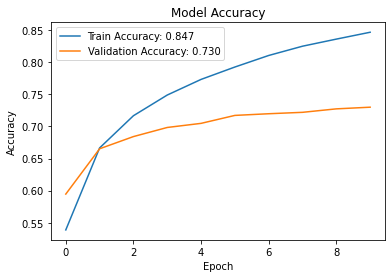

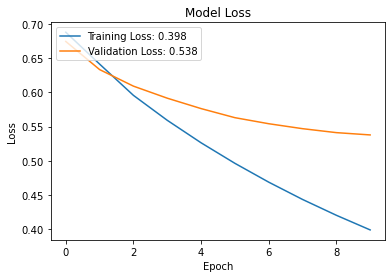

In [232]:
#Accuracy and Loss plot
accuracy_loss_plot(history6)


In [233]:
# Evaluate performance of the test dataset
print("Testing accuracy and Loss ")
m6 = model6.evaluate(x_test6, y_test)
accuracy = m6[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model6-LessHiddenDimen ',m6[1]*100])


Testing accuracy and Loss 
782/782 [==============================] - 9s 11ms/step - loss: 0.5373 - acc: 0.7312
Accuracy Testing dataset: 73.12


Time taken by the model with less hidden layers is almost the same as the model with more hidden layers. Also the model with more hidden dimension have almost the same accuracy compared to model with lower hidden dimension

## Train LSTM networks


14- Build LSTM and GRU networks and compare their performance (accuracy and execution time) with the SimpleRNN. What is your conclusion?

In [234]:
def build_model_lstm(max_features,embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
    model.add(LSTM(128, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
                 
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
                   loss='binary_crossentropy', 
                   metrics=['acc'])    
    return model

In [235]:
max_features = 20000  
maxlen = 80
embedding_dim = 50

#Load data with vocabulary size as 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Copy x_train and x_test to x_train5 and x_test5 for the building the model
x_train7,x_test7 = pad_seq(x_train,x_test,maxlen)



Pad sequences (samples x time)


In [236]:
model_lstm = build_model_lstm(max_features,embedding_dim, maxlen)
model_lstm.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 80, 50)            1000000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               91648     
                                                                 
 dense_33 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,091,777
Trainable params: 1,091,777
Non-trainable params: 0
_________________________________________________________________


In [237]:
model_lstm.count_params()

1091777

In [238]:
# set a timer to measure training time
start = timeit.default_timer()

history7= model_lstm.fit(x_train7, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
                    
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/10
625/625 [==============================] - 12s 16ms/step - loss: 0.6324 - acc: 0.6360 - val_loss: 0.5342 - val_acc: 0.7452
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 0.4668 - acc: 0.7861 - val_loss: 0.4414 - val_acc: 0.7942
Epoch 3/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3842 - acc: 0.8350 - val_loss: 0.3839 - val_acc: 0.8246
Epoch 4/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3396 - acc: 0.8575 - val_loss: 0.3715 - val_acc: 0.8314
Epoch 5/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3089 - acc: 0.8733 - val_loss: 0.3557 - val_acc: 0.8396
Epoch 6/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2888 - acc: 0.8806 - val_loss: 0.3458 - val_acc: 0.8450
Epoch 7/10
625/625 [==============================] - 10s 15ms/step - loss: 0.2731 - acc: 0.8891 - val_loss: 0.3422 - val_acc: 0.8458
Epoch 8/10
625/625 [==============================] - 10s 15ms

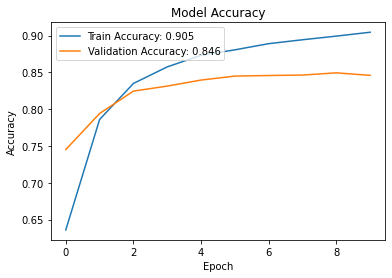

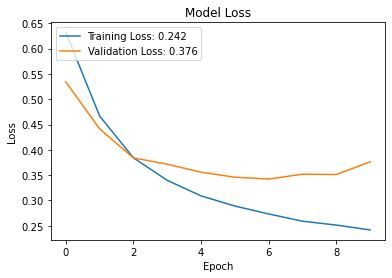

In [239]:
#Accuracy and Loss plot
accuracy_loss_plot(history7)


In [240]:
# Evaluate performance of the test dataset
print("Testing accuracy and Loss ")
m7 = model_lstm.evaluate(x_test7, y_test)
accuracy = m7[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model6 - LSTM          ',m7[1]*100])


Testing accuracy and Loss 
782/782 [==============================] - 6s 8ms/step - loss: 0.3800 - acc: 0.8449A: 0s - loss:
Accuracy Testing dataset: 84.49


LSTM has a better accuracy compared to SimpleRNN models. Moreover, the time taken by LSTM is far less compared to SimpleRNN.

## Train GRU networks

In [241]:
max_features = 20000  
maxlen = 80
embedding_dim = 50

#Load data with vocabulary size as 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#Copy x_train and x_test to x_train5 and x_test5 for the building the model
x_train8,x_test8 = pad_seq(x_train,x_test,maxlen)



Pad sequences (samples x time)


In [242]:
def build_model_gru(max_features,embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
    model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
                 
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
                   loss='binary_crossentropy', 
                   metrics=['acc'])    
    return model

In [243]:
model_gru = build_model_gru(max_features,embedding_dim, maxlen)
model_gru.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 80, 50)            1000000   
                                                                 
 gru_2 (GRU)                 (None, 32)                7968      
                                                                 
 dense_34 (Dense)            (None, 30)                990       
                                                                 
 dense_35 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,008,989
Trainable params: 1,008,989
Non-trainable params: 0
_________________________________________________________________


In [244]:
model_gru.count_params()

1008989

In [245]:

# set a timer to measure training time
start = timeit.default_timer()

history8= model_gru.fit(x_train8, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2)
                    
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/10
313/313 [==============================] - 426s 1s/step - loss: 0.6915 - acc: 0.5476 - val_loss: 0.6889 - val_acc: 0.5782
Epoch 2/10
313/313 [==============================] - 425s 1s/step - loss: 0.6814 - acc: 0.6198 - val_loss: 0.6726 - val_acc: 0.6382
Epoch 3/10
313/313 [==============================] - 433s 1s/step - loss: 0.6419 - acc: 0.6905 - val_loss: 0.6037 - val_acc: 0.7078
Epoch 4/10
313/313 [==============================] - 427s 1s/step - loss: 0.4820 - acc: 0.7841 - val_loss: 0.4267 - val_acc: 0.8018
Epoch 5/10
313/313 [==============================] - 422s 1s/step - loss: 0.3884 - acc: 0.8304 - val_loss: 0.3893 - val_acc: 0.8202
Epoch 6/10
313/313 [==============================] - 426s 1s/step - loss: 0.3464 - acc: 0.8536 - val_loss: 0.3687 - val_acc: 0.8346
Epoch 7/10
313/313 [==============================] - 424s 1s/step - loss: 0.3196 - acc: 0.8687 - val_loss: 0.3612 - val_acc: 0.8388
Epoch 8/10
313/313 [==============================] - 426s 1s/step - 

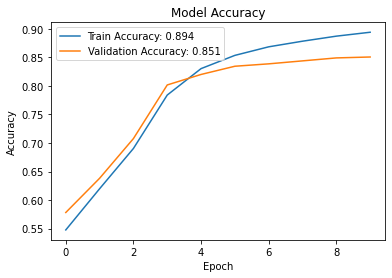

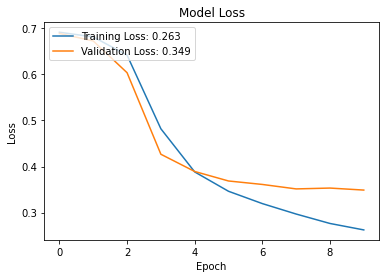

In [246]:
#Accuracy and Loss plot
accuracy_loss_plot(history8)


The GRU is gives the best accuracy. However, the model takes more time than all the other models.

In [247]:
# Evaluate performance of the test dataset
print("Testing accuracy and Loss ")
m8 = model_gru.evaluate(x_test8, y_test)
accuracy = m8[1] *100
print('Accuracy Testing dataset: %.2f' % accuracy)
models.append(['Model8 - GRU           ',m8[1]*100])


Testing accuracy and Loss 
782/782 [==============================] - 72s 92ms/step - loss: 0.3574 - acc: 0.8454
Accuracy Testing dataset: 84.54


In [248]:
# Plot the accuracies of a list of trained models.
print("Accuracy of all the models : ")
models

Accuracy of all the models : 


[['BaselineModel_Maxlen_30: ', 74.86400008201599],
 ['Model2-Maxlen_80:       ', 50.92800259590149],
 ['Model3-VocabSize_10,000', 79.94400262832642],
 ['Model4-VocabSize_40,000:', 51.099997758865356],
 ['Model5-MoreHiddenDimen ', 73.72400164604187],
 ['Model6-LessHiddenDimen ', 73.12399744987488],
 ['Model6 - LSTM          ', 84.49199795722961],
 ['Model8 - GRU           ', 84.54399704933167]]

Based on the accuracy of different models, it is clear that GRU has the highest accuracy. Hence, we save the Model with GRU.

In terms of time taken, we see that LSTM model takes the least amount of time and GRU takes more time than other models.

Saving the model

In [249]:
model_gru.save('Imdb-model.h5')

Predictions on Test with the best model

In [252]:
predictions = model_gru.predict(x_test8)


Predict on a random input and compare it with actual value

In [254]:
x_test8[1]

array([ 1669,   398,   229,    10,    10,    13,  2822,   670,  5304,
          14,     9,    31,     7,    27,   111,   108,    15,  2033,
          19,  7836,  1429,   875,   551,    14,    22,     9,  1193,
          21,    45,  4829,     5,    45,   252,     8, 12508,     6,
         565,   921,  3639,    39,     4,   529,    48,    25,   181,
           8,    67,    35,  1732,    22,    49,   238,    60,   135,
        1162,    14,     9,   290,     4,    58,    10,    10,   472,
          45,    55,   878,     8,   169,    11,   374,  5687,    25,
         203,    28,     8,   818,    12,   125,     4,  3077])

In [255]:
y_test[1]

1

In [258]:
predictions[1]

array([0.9614102], dtype=float32)

Prediction by Model_gru on the sample input sequence is correct